# Aashia Mehta
# CS 7641: Machine Learning
# Project 1: Supervised Learning

In [4]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import time

## Phishing Websites

In [88]:
# https://archive.ics.uci.edu/ml/datasets/phishing+websites
phishing_dataset = pd.read_csv('phishing_websites.csv') 

# https://note.nkmk.me/en/python-pandas-len-shape-size/
phishing_dataset.drop(columns=phishing_dataset.columns[0], 
        axis=1, 
        inplace=True)
print("# of Rows: ", len(phishing_dataset))
print("# of Columns: ", len(phishing_dataset.columns))

num_unique_rows = phishing_dataset.drop_duplicates().shape[0]
print("# of Unique Rows: ", num_unique_rows)
print("% of Unique Rows: ", num_unique_rows / len(phishing_dataset))



# https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.shape.html
phishing_X = phishing_dataset.iloc[:,:-1]
phishing_Y = phishing_dataset.iloc[: , -1]
print("X Shape: ", phishing_X.shape)
print("Y Shape: ", phishing_Y.shape)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# 30-70 split
phishing_X_train, phishing_X_test, phishing_Y_train, phishing_Y_test = train_test_split(phishing_X, phishing_Y, test_size=0.30, random_state=5)
print("X Train Shape: ", phishing_X_train.shape)
print("X Test Shape: ", phishing_X_test.shape)
print("Y Train Shape: ", phishing_Y_train.shape)
print("Y Test Shape: ", phishing_Y_test.shape)

phishing_dataset.head()

# of Rows:  11055
# of Columns:  31
X Shape:  (11055, 30)
Y Shape:  (11055,)
# of Unique Rows:  5849
X Train Shape:  (7738, 30)
X Test Shape:  (3317, 30)
Y Train Shape:  (7738,)
Y Test Shape:  (3317,)


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [77]:
# https://chrisalbon.com/code/machine_learning/model_evaluation/plot_the_validation_curve/
def create_validation_curve(classifier, X, Y, param_name, param_range, title, x_label):
    # Calculate accuracy on training and test set using range of parameter values
    train_scores, test_scores = validation_curve(classifier, 
                                                 X, 
                                                 Y, 
                                                 param_name=param_name, 
                                                 param_range=param_range,
                                                 cv=3, 
                                                 scoring="accuracy", 
                                                 n_jobs=-1)


    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot mean accuracy scores for training and test sets
    plt.plot(param_range, train_mean, label="Training score", color="lightcoral")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="gold")

    # Plot accurancy bands for training and test sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="mistyrose")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="lemonchiffon")

    # Create plot
    plt.title("Validation Curve With " + title)
    plt.xlabel(x_label)
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()
    
# https://chrisalbon.com/code/machine_learning/model_evaluation/plot_the_learning_curve/
def create_learning_curve(classifier, X, Y, title):
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(classifier, 
                                                            X, 
                                                            Y,
                                                            cv=3,
                                                            scoring='accuracy',
                                                            n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1.0, 5))

    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="lightcoral",  label="Training score")
    plt.plot(train_sizes, test_mean, color="gold", label="Cross-validation score")

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="mistyrose")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="lemonchiffon")

    # Create plot
    plt.title("Learning Curve With " + title)
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

### Decision Tree

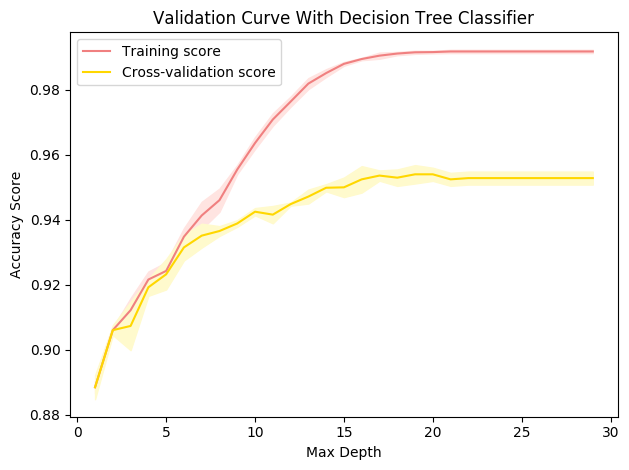

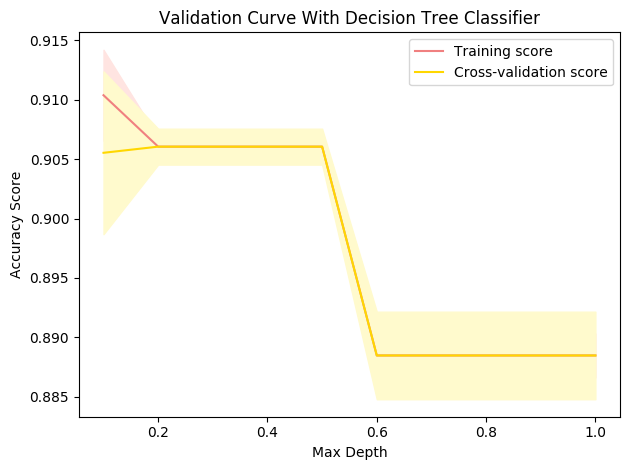

In [78]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
phishing_dt = DecisionTreeClassifier(random_state=5)

create_validation_curve(phishing_dt, phishing_X_train, phishing_Y_train, "max_depth", np.arange(1, 30), "Decision Tree Classifier", "Max Depth")
create_validation_curve(phishing_dt, phishing_X_train, phishing_Y_train, "min_samples_split", np.linspace(0.1, 1.0, 10), "Decision Tree Classifier", "Max Depth")

Accuracy w/o Tuning:  0.9656315948145915
Best Params:  {'max_depth': 19} DecisionTreeClassifier(max_depth=19, random_state=5)
Accuracy w/ Tuning:  0.964124208622249


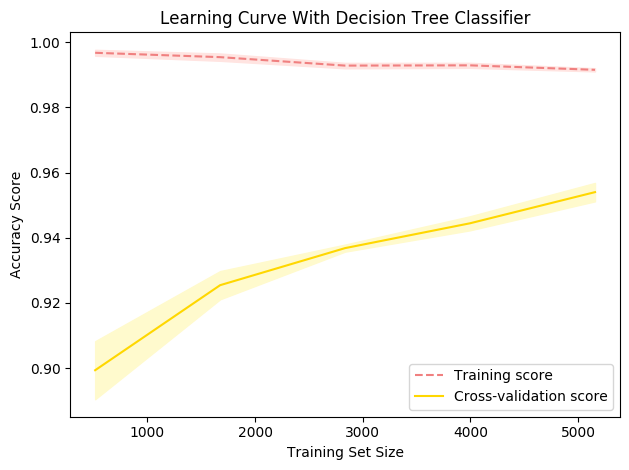

In [79]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
phishing_dt.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = phishing_dt.predict(phishing_X_test)
phishing_dt_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/o Tuning: ", phishing_dt_accuracy)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {"max_depth": np.arange(1, 30)}
phishing_dt_tuned = GridSearchCV(phishing_dt, param_grid, scoring='accuracy', cv=3)
phishing_dt_tuned.fit(phishing_X_train, phishing_Y_train)
best_params = phishing_dt_tuned.best_params_
best_estimator = phishing_dt_tuned.best_estimator_
print("Best Params: ", best_params, best_estimator)

final_phishing_dt = best_estimator
final_phishing_dt.fit(phishing_X_train, phishing_Y_train)
phishing_Y_pred = final_phishing_dt.predict(phishing_X_test)
final_phishing_dt_accuracy = accuracy_score(phishing_Y_test, phishing_Y_pred)
print("Accuracy w/ Tuning: ", final_phishing_dt_accuracy)

create_learning_curve(final_phishing_dt, phishing_X_train, phishing_Y_train, "Decision Tree Classifier")

### Boosting

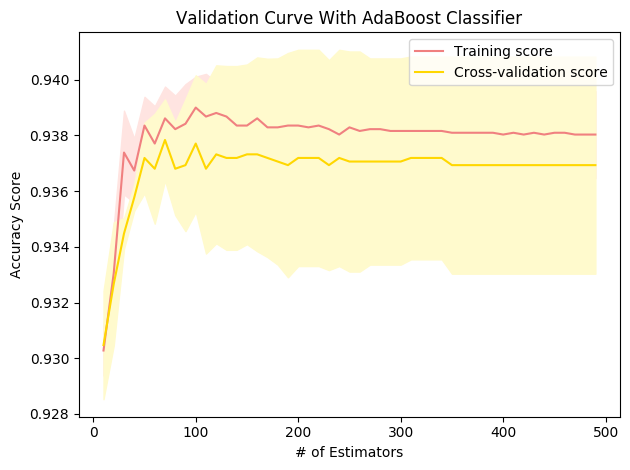

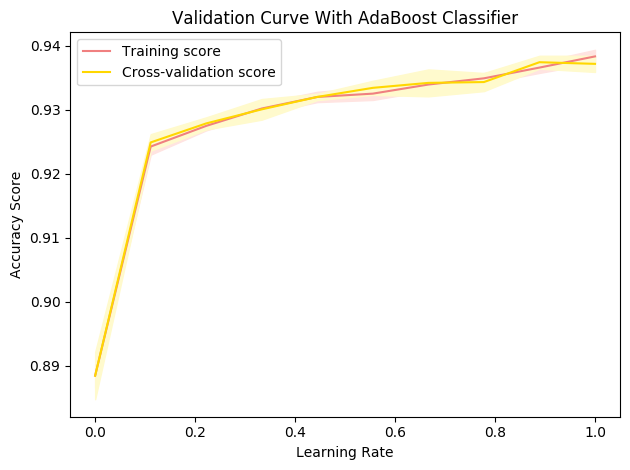

In [87]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
phishing_boosting_dt = DecisionTreeClassifier(max_depth=1, random_state=5)
phishing_boosting = AdaBoostClassifier(phishing_boosting_dt, random_state=5)

create_validation_curve(phishing_boosting, phishing_X_train, phishing_Y_train, "n_estimators", np.arange(10, 500, 10), "AdaBoost Classifier", "# of Estimators")
create_validation_curve(phishing_boosting, phishing_X_train, phishing_Y_train, "learning_rate", np.linspace(0.001, 1.0, 10), "AdaBoost Classifier", "Learning Rate")

### SVM

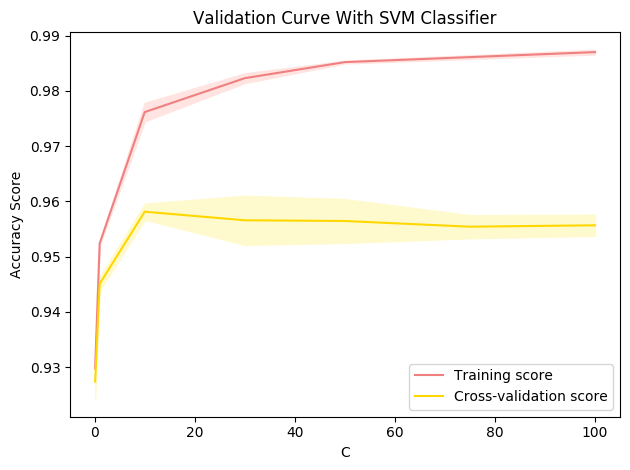

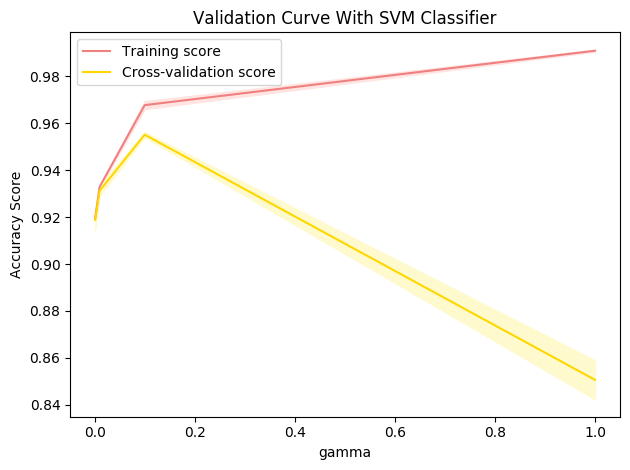

In [92]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
phishing_svm = SVC(random_state=5)

create_validation_curve(phishing_svm, phishing_X_train, phishing_Y_train, "C", [0.1, 1, 10, 30, 50, 75, 100], "SVM Classifier", "C")
create_validation_curve(phishing_svm, phishing_X_train, phishing_Y_train, "gamma", [0.001, 0.01, 0.1, 1], "SVM Classifier", "gamma")
# create_validation_curve(phishing_svm, phishing_X_train, phishing_Y_train, "kernel", ['linear', 'rbf', 'poly', 'sigmoid', 'precomputed'], "SVM Classifier", "kernel")

### KNN

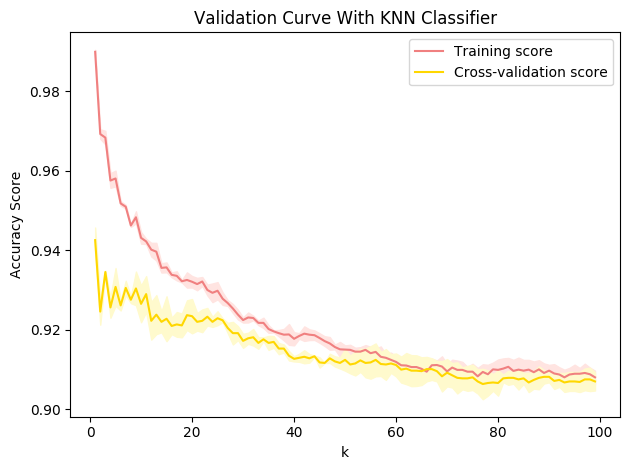

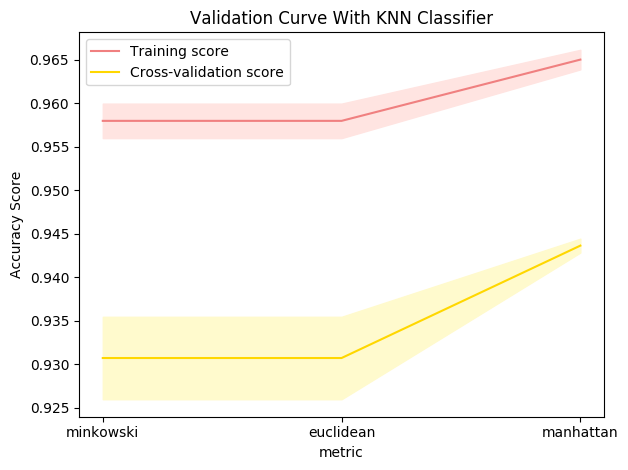

In [93]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
phishing_knn = KNeighborsClassifier()

create_validation_curve(phishing_knn, phishing_X_train, phishing_Y_train, "n_neighbors", list(range(1, 100)), "KNN Classifier", "k")
create_validation_curve(phishing_knn, phishing_X_train, phishing_Y_train, "metric", ['minkowski', 'euclidean', 'manhattan'], "KNN Classifier", "metric")

### Neural Networks

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
phishing_mlp = MLPClassifier(random_state=5)

create_validation_curve(phishing_mlp, phishing_X_train, phishing_Y_train, "hidden_layer_sizes", [(100,), (100, 100), (200,), (200, 200), (100, 200), (200, 100)], "MLP Classifier", "Hidden Layer Sizes")
create_validation_curve(phishing_mlp, phishing_X_train, phishing_Y_train, "learning_rate_init", [0.001, 0.01, 0.1, 0.5, 1], "MLP Classifier", "Learning Rate Init")

## Wine Quality

In [19]:
# https://archive.ics.uci.edu/ml/datasets/wine+quality
wine_dataset = pd.read_csv('wine_quality.csv')  
print("# of Rows: ", len(wine_dataset))
print("# of Columns: ", len(wine_dataset.columns))

# https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.shape.html
wine_X = wine_dataset.iloc[:,:-1]
wine_Y = wine_dataset.iloc[: , -1]
print("X Shape: ", wine_X.shape)
print("Y Shape: ", wine_Y.shape)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# 30-70 split
wine_X_train, wine_X_test, wine_Y_train, wine_Y_test = train_test_split(wine_X, wine_Y, test_size=0.30, random_state=5)
print("X Train Shape: ", wine_X_train.shape)
print("X Test Shape: ", wine_X_test.shape)
print("Y Train Shape: ", wine_Y_train.shape)
print("Y Test Shape: ", wine_Y_test.shape)

wine_dataset.head()

# of Rows:  1599
# of Columns:  12
X Shape:  (1599, 11)
Y Shape:  (1599,)
X Train Shape:  (1119, 11)
X Test Shape:  (480, 11)
Y Train Shape:  (1119,)
Y Test Shape:  (480,)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
